In [20]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import os,sys
import io
from PIL import Image
import tensorflow as tf
from IPython.display import clear_output
import tensorflow_datasets as tfds
import tensorflow.io as tfio
from glob import glob
import time
import datetime
from tensorflow import keras
from tensorflow.keras import layers
#from keras.models import *
#from keras.layers import *

%load_ext autoreload
%autoreload 2

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

#https://www.tensorflow.org/tutorials/images/segmentation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Tensorflow ver. 2.4.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

## Creating our Dataloader

In [3]:
SEED = 42

dataset_path = "training/" 
training_data = "images/"
val_data = "test_set/"

# Image size that we are going to use
IMG_SIZE = 400
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 150 classes + `not labeled`
N_CLASSES = 2

In [4]:
TRAINSET_SIZE = len(glob(dataset_path + training_data + "*.png"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")
print(dataset_path + training_data + "*.png")


Groundtruth_SIZE = len(glob(dataset_path + "groundtruth/" + "*.png"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")
print(dataset_path + training_data + "*.png")



VALSET_SIZE = len(glob(val_data +training_data+ "*.png"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")


The Training Dataset contains 100 images.
training/images/*.png
The Training Dataset contains 100 images.
training/images/*.png
The Validation Dataset contains 50 images.


In [5]:
from helper_unet import parse_image

train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.png", seed=SEED)
train_dataset = train_dataset.map(parse_image)
print(len(train_dataset))

val_dataset = tf.data.Dataset.list_files(val_data + training_data+"*.png", seed=SEED)
val_dataset =val_dataset.map(parse_image)
print(len(val_dataset))

100
50


## Applying some transformations to our dataset

In [6]:
from helper_unet import load_image_test, load_image_train

BATCH_SIZE = 32

BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])


<PrefetchDataset shapes: ((None, 400, 400, 3), (None, 400, 400, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 400, 400, 3), (None, 400, 400, 1)), types: (tf.float32, tf.float32)>


##  Visualizing the Dataset

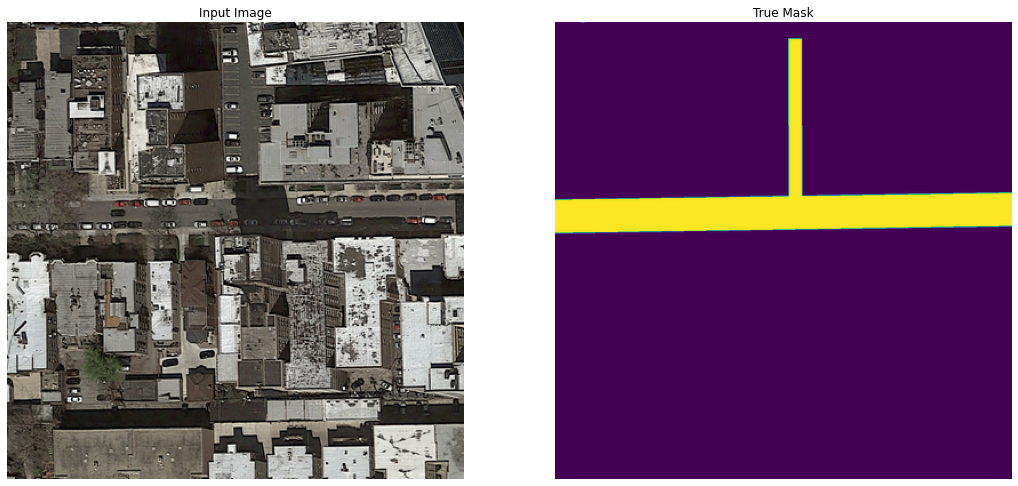

In [7]:
from helper_unet import display_sample

for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask
    display_sample([sample_image[0], sample_mask[0]])


## Developing the Model (UNet) Using Keras Functional API


In [220]:
data_dir = './training/'
train_data_filename = data_dir + 'images/'
train_labels_filename = data_dir + 'groundtruth/'

def load_image(infilename:str):
    """ Loads the image specified by the filename (string) passed as argument.
        __________
        Parameters : filename (str)
        Returns : image (torch tensor) 
    """
    
    data = mpimg.imread(infilename)
    return torch.from_numpy(data)

def load_nimages(n, train=True, filters=None, seed=1):
    """ Loads n (int) images in an arbitrary order and returns a list of these 
        and another of their corresponding groundtruths if the argument train 
        is set to True (default). Otherwise, it returns one list of test images.
        It is also possible to precise a list of filters with values specified 
        inside method features.filter_img (default: None).
        __________
        Parameters : n (int), train=True (boolean), filters=None (list of str)
        Returns : images (list of torch tensors), 
                  groundtruths (list of torch tensors) (if train=True),
                  filtered images (list of torch tensors) (if filters!=None)
    """
        
    if train:
        root_dir = "./training/"
        image_dir = root_dir + "images/"
        gt_dir = root_dir + "groundtruth/"
    
        files = np.array(sorted(os.listdir(image_dir)))
        np.random.seed(seed) # Seeding so everyone gets the same samples
        random_indices = np.random.permutation(len(files))
        files = files[random_indices]
        n = min(n, len(files)) # Load maximum n images
        
        print("Loading " + str(n) + " images")
        imgs = [load_image(image_dir + files[i]) for i in range(n)]
        
        print("Loading " + str(n) + " corresponding groundtruths")
        gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
        
    
        return imgs, gt_imgs
imgs, gts = load_nimages(10, seed=1)
    

img_torch = torch.stack(imgs)
gts_torch = torch.stack(gts)
imgs 
   

Loading 10 images
Loading 10 corresponding groundtruths


[tensor([[[0.5098, 0.5176, 0.5098],
          [0.5294, 0.5412, 0.5294],
          [0.4667, 0.4902, 0.4863],
          ...,
          [0.3412, 0.3294, 0.2824],
          [0.3412, 0.3216, 0.2784],
          [0.4039, 0.3725, 0.3333]],
 
         [[0.5255, 0.5255, 0.4980],
          [0.5804, 0.5804, 0.5608],
          [0.5569, 0.5647, 0.5490],
          ...,
          [0.3451, 0.3294, 0.2902],
          [0.4314, 0.4118, 0.3765],
          [0.4667, 0.4431, 0.4118]],
 
         [[0.5804, 0.5686, 0.5294],
          [0.4392, 0.4353, 0.3922],
          [0.4667, 0.4627, 0.4275],
          ...,
          [0.0941, 0.0902, 0.0706],
          [0.1373, 0.1333, 0.1137],
          [0.1765, 0.1647, 0.1490]],
 
         ...,
 
         [[0.1098, 0.1137, 0.0863],
          [0.0863, 0.0980, 0.0588],
          [0.2235, 0.2471, 0.1804],
          ...,
          [0.3804, 0.3647, 0.3333],
          [0.4588, 0.4431, 0.4078],
          [0.5176, 0.4980, 0.4667]],
 
         [[0.1765, 0.1882, 0.1451],
          [0

In [221]:
def double_conv(input_channel, output_channel):
    conv = nn.Sequential(
        nn.Conv2d(input_channel,output_channel, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(output_channel,output_channel, kernel_size=3),
        nn.ReLU(inplace=True),
    )
    return conv

#to have the same size when concatenate
def crop_img(tensor,target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    #delta1 = delta/2
    if delta%2==0:
        delta = delta//2
        return tensor[:,:,delta:tensor_size-delta,delta:tensor_size-delta]
    else:
        delta = delta//2
        a = delta+1
        return tensor[:,:,a:tensor_size-delta,a:tensor_size-delta]

In [222]:

int(3.5)

3

In [223]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet,self).__init__()
    
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.down_conv_1 = double_conv(1,64)
        self.down_conv_2 = double_conv(64,128)
        self.down_conv_3 = double_conv(128,256)
        self.down_conv_4 = double_conv(256,512)
        self.down_conv_5 = double_conv(512,1024)
        
        self.up_trans_1 = nn.ConvTranspose2d(in_channels = 1024,out_channels=512,kernel_size=2,stride=2)
        
        self.up_conv_1 = double_conv(1024,512)
        
        self.up_trans_2 = nn.ConvTranspose2d(in_channels = 512,out_channels=256,kernel_size=2,stride=2)
        
        self.up_conv_2 = double_conv(512,256)
        
        self.up_trans_3 = nn.ConvTranspose2d(in_channels = 256,out_channels=128,kernel_size=2,stride=2)
        
        self.up_conv_3 = double_conv(256,128)
        
        self.up_trans_4 = nn.ConvTranspose2d(in_channels = 128,out_channels=64,kernel_size=2,stride=2)
        
        self.up_conv_4 = double_conv(128,64)
        
        self.out = nn.Conv2d(in_channels = 64,out_channels = 2,kernel_size = 1)
        
    def forward(self,image):
    #encoder
        x1 = self.down_conv_1(image)
        print(x1.size())
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)
        print(x9.size())
            
        #decoder
        x = self.up_trans_1(x9)
        print(x.size())
        y = crop_img(x7,x)
        x = self.up_conv_1(torch.cat([x,y],1))
            
        x = self.up_trans_2(x)
        y = crop_img(x5,x)
        x = self.up_conv_2(torch.cat([x,y],1))
            
        x = self.up_trans_3(x)
        y = crop_img(x3,x)
        x = self.up_conv_3(torch.cat([x,y],1))
            
        x = self.up_trans_4(x)
        y = crop_img(x1,x)
        x = self.up_conv_4(torch.cat([x,y],1))
            
        x = self.out(x)
        print(x.size)
        return x #number of channels 2
   

In [229]:
class UNet1(nn.Module):
    def __init__(self):
        super(UNet1,self).__init__()
    
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.down_conv_1 = double_conv(1,50)
        self.down_conv_2 = double_conv(50,100)
        self.down_conv_3 = double_conv(100,200)
        self.down_conv_4 = double_conv(200,400)
        self.down_conv_5 = double_conv(400,800)
        
        self.up_trans_1 = nn.ConvTranspose2d(in_channels = 800,out_channels=400,kernel_size=2,stride=2)
        
        self.up_conv_1 = double_conv(800,400)
        
        self.up_trans_2 = nn.ConvTranspose2d(in_channels = 400,out_channels=200,kernel_size=2,stride=2)
        
        self.up_conv_2 = double_conv(400,200)
        
        self.up_trans_3 = nn.ConvTranspose2d(in_channels = 200,out_channels=100,kernel_size=2,stride=2)
        
        self.up_conv_3 = double_conv(200,100)
        
        self.up_trans_4 = nn.ConvTranspose2d(in_channels = 100,out_channels=50,kernel_size=2,stride=2)
        
        self.up_conv_4 = double_conv(100,50)
        
        self.out = nn.Conv2d(in_channels = 50,out_channels = 2,kernel_size = 1)
        
    def forward(self,image):
    #encoder
       
        x1 = self.down_conv_1(image)
        
        x2 = self.max_pool_2x2(x1)
        
        x3 = self.down_conv_2(x2)
        
        x4 = self.max_pool_2x2(x3)
        
        x5 = self.down_conv_3(x4)
        
        x6 = self.max_pool_2x2(x5)
      
        x7 = self.down_conv_4(x6)
        
        x8 = self.max_pool_2x2(x7)
        
        x9 = self.down_conv_5(x8)
        
        #decoder
      
        x = self.up_trans_1(x9)
        
        y = crop_img(x7,x)
       
        x = self.up_conv_1(torch.cat([x,y],1))
        
            
        x = self.up_trans_2(x)
        
        y = crop_img(x5,x)
        
        x = self.up_conv_2(torch.cat([x,y],1))
        
            
        x = self.up_trans_3(x)
        
        y = crop_img(x3,x)
       
        x = self.up_conv_3(torch.cat([x,y],1))
        
            
        x = self.up_trans_4(x)
        y = crop_img(x1,x)
        x = self.up_conv_4(torch.cat([x,y],1))
            
        x = self.out(x)
        
        return x #number of channels 2
   

In [228]:
#image = torch.rand((1,1,400,400)) 
#572 size of the image #channel=1 #batch = 1

model = UNet1()



    

             

In [136]:
model = tf.keras.Model(inputs = inputs, outputs = output_layer)
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss = 'binary_crossentropy', metrics=['accuracy'])

model.summary()
return model

model = unet_model()



NameError: name 'inputs' is not defined

In [230]:
from helper_unet import create_mask, show_predictions


for image, mask in dataset['train'].take(2):
    sample_image, sample_mask = image, mask
    one_img_batch = sample_image[0][tf.newaxis, ...]
    inference = model.predict(one_img_batch)
    pred_mask = create_mask(inference)
    display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])





AttributeError: 'UNet1' object has no attribute 'predict'

In [30]:
EPOCHS = 1

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

model_history = model.fit(dataset['train'], epochs=EPOCHS,
steps_per_epoch=STEPS_PER_EPOCH,
validation_steps=VALIDATION_STEPS,
validation_data=dataset['val'], callbacks=[DisplayCallback()])



3/3 [==============================] - ETA: 0s - loss: -18.6497 - accuracy: 0.1406 

NotFoundError:  test_set/groundtruth/test_50.png; No such file or directory
	 [[{{node ReadFile_1}}]]
	 [[IteratorGetNext]] [Op:__inference_test_function_6046]

Function call stack:
test_function
